<a href="https://colab.research.google.com/github/DanielDLX/DLfinal/blob/master/bert_AGnews_3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# 导入包
# transformer提供了一些训练好的模型，可以很方便的使用。
!pip install transformers
import tensorflow as tf
import pandas as pd
import os
import numpy as np
import sklearn
from sklearn.manifold import TSNE
import tqdm
# 使用分类的模型，增加了一个head用于分类。
from transformers import BertTokenizer, TFBertForSequenceClassification
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import math
% matplotlib inline

tf.__version__

'2.2.0'

In [2]:
# 导入现成的分词器
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

In [3]:
# 数据链接，可以在 https://course.fast.ai/datasets 找到。
# agnews数据集，类别，标题，描述。
ag_url = 'https://s3.amazonaws.com/fast-ai-nlp/ag_news_csv.tgz'

In [4]:
# 下载数据，并指定此时数据集的目录
ag_zip_file = tf.keras.utils.get_file(origin=ag_url,fname='ag_news_csv.tgz', extract=True)
base_dir = os.path.join(os.path.dirname(ag_zip_file), 'ag_news_csv')
os.listdir(base_dir)

['test.csv', 'classes.txt', 'train.csv', 'readme.txt']

In [5]:
# 读取数据
# 为了方便测试代码的时候少用几个数据,1000个数据可以让准确率上升到0.68
# num = 1500
train = pd.read_csv(os.path.join(base_dir, 'train.csv'), header=None)
# train = train.sample(n=num)
print(len(train))
print(train.head())
test = pd.read_csv(os.path.join(base_dir, 'test.csv'), header=None)
# test = test.sample(n=num)
print(len(test))
print(test.head())
f = open(os.path.join(base_dir, 'classes.txt'))
classes = f.readlines()
classes = [s.strip() for s in classes]
print(classes)

120000
   0  ...                                                  2
0  3  ...  Reuters - Short-sellers, Wall Street's dwindli...
1  3  ...  Reuters - Private investment firm Carlyle Grou...
2  3  ...  Reuters - Soaring crude prices plus worries\ab...
3  3  ...  Reuters - Authorities have halted oil export\f...
4  3  ...  AFP - Tearaway world oil prices, toppling reco...

[5 rows x 3 columns]
7600
   0  ...                                                  2
0  3  ...  Unions representing workers at Turner   Newall...
1  4  ...  SPACE.com - TORONTO, Canada -- A second\team o...
2  4  ...  AP - A company founded by a chemistry research...
3  4  ...  AP - It's barely dawn when Mike Fitzpatrick st...
4  4  ...  AP - Southern California's smog-fighting agenc...

[5 rows x 3 columns]
['World', 'Sports', 'Business', 'Sci/Tech']


In [6]:
# 预处理数据
# 按照上面的例子把数据集中的文本进行分词处理，并且得到对应的labels。
max_length = 256
max_length_temp = max_length - 2
train_ids = []
test_ids = []
for i in tqdm.notebook.trange(train.shape[0]):
  if len(train[2][train[2].index[i]]) > max_length_temp:
    train_ids.append(tokenizer.encode(text=train[2][train[2].index[i]][0 : max_length_temp], padding='max_length', max_length=max_length, return_tensors="tf"))
  else:
    train_ids.append(tokenizer.encode(text=train[2][train[2].index[i]], padding='max_length', max_length=max_length, return_tensors="tf"))
for i in tqdm.notebook.trange(test.shape[0]):
  if len(test[2][test[2].index[i]]) > max_length_temp:
    test_ids.append(tokenizer.encode(text=test[2][test[2].index[i]][0 : max_length_temp], padding='max_length', max_length=max_length, return_tensors="tf"))
  else:
    test_ids.append(tokenizer.encode(text=test[2][test[2].index[i]], padding='max_length', max_length=max_length, return_tensors="tf"))
train_labels = train[0].values - 1
test_labels = test[0].values - 1

In [7]:
# 把数据转成tensorflow张量
# train_ids是tf.Tensor组成得列表，所以用concat组合一下就行
train_ids = tf.concat(train_ids, 0)
# 把train_mask初始化为1，然后把train_ids等于0（PAD的部分）对应的值赋为0
train_mask = tf.ones(train_ids.shape)
train_mask = tf.where(tf.math.greater(train_ids, 0), train_mask, 0)
# labels本身是numpy数组，转为tf.Tensor
train_labels = tf.convert_to_tensor(train_labels)

# 测试集的处理同理test
test_ids = tf.concat(test_ids, 0)
test_mask = tf.ones(test_ids.shape)
test_mask = tf.where(tf.math.greater(test_ids, 0), test_mask, 0)
test_labels = tf.convert_to_tensor(test_labels)

In [8]:
print(train_ids[0])
print(train_mask[0])
print(train_labels[0])

tf.Tensor(
[  101 26665  1011  2460  1011 19041  1010  2813  2395  1005  1055  1040
 11101  2989  1032  2316  1997 11087  1011 22330  8713  2015  1010  2024
  3773  2665  2153  1012   102     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0    

In [9]:
# 训练参数
epochs = 2
batch_size = 16
validation_rate = 0.1

In [10]:
# 模型放在这里
model = TFBertForSequenceClassification.from_pretrained("bert-base-uncased", num_labels=4) # 分类类别数
model.summary()
model.config

Some weights of the model checkpoint at bert-base-uncased were not used when initializing TFBertForSequenceClassification: ['mlm___cls', 'nsp___cls']
- This IS expected if you are initializing TFBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPretraining model).
- This IS NOT expected if you are initializing TFBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of TFBertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['dropout_37', 'classifier']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Model: "tf_bert_for_sequence_classification"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
bert (TFBertMainLayer)       multiple                  109482240 
_________________________________________________________________
dropout_37 (Dropout)         multiple                  0         
_________________________________________________________________
classifier (Dense)           multiple                  3076      
Total params: 109,485,316
Trainable params: 109,485,316
Non-trainable params: 0
_________________________________________________________________


BertConfig {
  "architectures": [
    "BertForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "id2label": {
    "0": "LABEL_0",
    "1": "LABEL_1",
    "2": "LABEL_2",
    "3": "LABEL_3"
  },
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "label2id": {
    "LABEL_0": 0,
    "LABEL_1": 1,
    "LABEL_2": 2,
    "LABEL_3": 3
  },
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 0,
  "type_vocab_size": 2,
  "vocab_size": 30522
}

In [52]:
# 简单分类算法
model_compare = tf.keras.Sequential([
    tf.keras.layers.Embedding(30522, 768),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64)),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(4)
])
model_compare.summary()

Model: "sequential_13"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_13 (Embedding)     (None, None, 768)         23440896  
_________________________________________________________________
bidirectional_7 (Bidirection (None, 128)               426496    
_________________________________________________________________
dense_26 (Dense)             (None, 64)                8256      
_________________________________________________________________
dense_27 (Dense)             (None, 4)                 260       
Total params: 23,875,908
Trainable params: 23,875,908
Non-trainable params: 0
_________________________________________________________________


In [12]:
# 模型编译
optimizer = tf.keras.optimizers.Adam(learning_rate=3e-5, epsilon=1e-08, clipnorm=1.0)
loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
metric = tf.keras.metrics.SparseCategoricalAccuracy('accuracy')
model.compile(optimizer=optimizer, loss=loss, metrics=[metric])

In [53]:
def learn_rate(ep):
  return 0.001 / (math.pow(10, ep))
LRS = tf.keras.callbacks.LearningRateScheduler(learn_rate)
optimizer_compare = tf.keras.optimizers.Adam(learning_rate=0.001, epsilon=1e-08, clipnorm=1.0)
model_compare.compile(optimizer=optimizer_compare, loss=loss, metrics=[metric])

In [14]:
# history是按照一个epoch记录一次，间隔太大了，所以手动重写一个基于batch的
class BatchCallback(tf.keras.callbacks.History):
  def __init__(self):
    self.batch = []
    self.history = {'loss':[], 'accuracy':[]}
  def on_train_batch_end(self, batch, logs=None):
    self.batch.append(batch)
    for k, v in logs.items():
      self.history[k].append(v)

In [15]:
# 模型训练
history = model.fit(x=[train_ids, train_mask], 
     y=train_labels, 
     batch_size=batch_size, 
     epochs=epochs, 
     verbose=1, 
     callbacks=[BatchCallback()],
     shuffle=True)

Epoch 1/2
7500/7500 [==============================] - 3670s 489ms/step - loss: 0.2331 - accuracy: 0.9197
Epoch 2/2
7500/7500 [==============================] - 3674s 490ms/step - loss: 0.1461 - accuracy: 0.9499


In [54]:
history_compare = model_compare.fit(
    x=[train_ids, train_mask],
    y=train_labels,
    batch_size=batch_size, 
    epochs=epochs,
    verbose=1,
    callbacks=[BatchCallback(), LRS],
    shuffle=True
)

Epoch 1/2
7500/7500 [==============================] - 1764s 235ms/step - loss: 0.3342 - accuracy: 0.8541 - lr: 0.0010
Epoch 2/2
7500/7500 [==============================] - 1790s 239ms/step - loss: 0.1687 - accuracy: 0.9420 - lr: 1.0000e-04


In [56]:
# 模型测试
model.evaluate(x=[test_ids, test_mask],
        y=test_labels, 
        batch_size=4, 
        verbose=1)

1900/1900 [==============================] - 85s 45ms/step - loss: 0.1992 - accuracy: 0.9351


[0.19919265806674957, 0.9351315498352051]

In [57]:
model_compare.evaluate(x=[test_ids, test_mask],
        y=test_labels, 
        batch_size=4, 
        verbose=1)

1900/1900 [==============================] - 18s 9ms/step - loss: 0.2632 - accuracy: 0.9128


[0.263241171836853, 0.9127631783485413]

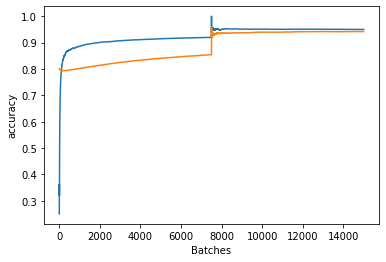

In [58]:
# 画图
def plot_graphs(history,history_compare, metric):
  plt.plot(history.history[metric])
  plt.plot(history_compare.history[metric])
  plt.xlabel("Batches")
  plt.ylabel(metric)
  plt.show()
plot_graphs(history, history_compare, 'accuracy')

In [59]:
index = None
for idx, layer in enumerate(model_compare.layers):
  print(idx, layer.name)

0 embedding_13
1 bidirectional_7
2 dense_26
3 dense_27


In [60]:
# 得到RNN模型embedding的方法，get embedding层后，输入词的id，得到embeding
# 用index更好
embedding_compare = model_compare.get_layer(index=0)

In [ ]:
# 得到每个类的embedding
avg_pool1 = tf.keras.layers.AveragePooling2D(pool_size=(max_length, 1))
N = tf.shape(train_ids)[0] // 1000
embs_list = []
for i in range(N):
  embs = embedding_compare(train_ids[i*1000:(i+1)*1000])
  embs = tf.reshape(avg_pool1(tf.reshape(embs,[-1,256,768,1])), [-1,768])
  embs_list.append(embs)
embs = embedding_compare(train_ids[N*1000:])
embs = tf.reshape(avg_pool1(tf.reshape(embs,[-1,256,768,1])), [-1,768])
embs_list.append(embs)
seq_embs_compare = tf.concat(embs_list, 0)
class_embedding_compare = np.zeros([4,768])
for i in range(4):
  index = train_labels == i
  class_embs = seq_embs_compare[index]
  avg_pool2 = tf.keras.layers.AveragePooling2D(pool_size=(tf.shape(class_embs)[0], 1))
  class_embs = tf.reshape(class_embs,[1,-1,768,1])
  class_embs = avg_pool2(class_embs)
  class_embedding_compare[i] = tf.reshape(class_embs, [768]).numpy()
print(class_embedding_compare)

In [ ]:
# 获得bert Embedding的方式，这里得到是整个embedding张量
embeddings = model.get_layer('bert').embeddings.word_embeddings

# 定义函数：通过词id 得到embedding
def get_embedding(input_ids, embeddings=embeddings):
  embeds = tf.gather(embeddings, input_ids)
  return embeds

In [ ]:
# 得到每个类的embedding
N = tf.shape(train_ids)[0] // 1000
embs_list = []
for i in range(N):
  embs = get_embedding(train_ids[i*1000:(i+1)*1000])
  embs = tf.reshape(avg_pool1(tf.reshape(embs,[-1,256,768,1])), [-1,768])
  embs_list.append(embs)
embs = get_embedding(train_ids[N*1000:])
embs = tf.reshape(avg_pool1(tf.reshape(embs,[-1,256,768,1])), [-1,768])
embs_list.append(embs)
seq_embs = tf.concat(embs_list, 0)
print(seq_embs)
class_embedding = np.zeros([4,768])
for i in range(4):
  index = train_labels == i
  class_embs = seq_embs[index]
  avg_pool2 = tf.keras.layers.AveragePooling2D(pool_size=(tf.shape(class_embs)[0], 1))
  class_embs = tf.reshape(class_embs,[1,-1,768,1])
  class_embs = avg_pool2(class_embs)
  class_embedding[i] = tf.reshape(class_embs, [768]).numpy()
print(class_embedding)

In [ ]:
# 类表征的余弦相似性
res = sklearn.metrics.pairwise.cosine_similarity(class_embedding, class_embedding_compare)
plt.imshow(res)
plt.show()

In [ ]:
# t-SNE分析,画图
def plot_scatter(emb, y_label, flag):
  t_sne_temp = TSNE(n_components=2).fit_transform(emb)
  y_label = [x + 10 * flag for x in y_label]
  plt.scatter(t_sne_temp[:,0], t_sne_temp[:,1], c=y_label)

In [ ]:
y_label = train_labels.numpy().tolist()
plot_scatter(seq_embs, y_label, 0)
plt.show()

In [ ]:
plot_scatter(seq_embs_compare, y_label, 1)
plt.show()

In [ ]:
def plot_graphs(history1, history2, history3, metric, labels):
  plt.plot(history1.history[metric], label=labels[0])
  plt.plot(history2.history[metric], label=labels[1])
  plt.plot(history3.history[metric], label=labels[2])
  plt.xlabel("Batches")
  plt.ylabel(metric)
  plt.legend()
  plt.show()

In [ ]:
model = TFBertForSequenceClassification.from_pretrained("bert-base-uncased", num_labels=4)
optimizer = tf.keras.optimizers.Adam(learning_rate=3e-4, epsilon=1e-08, clipnorm=1.0)
loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
metric = tf.keras.metrics.SparseCategoricalAccuracy('accuracy')
model.compile(optimizer=optimizer, loss=loss, metrics=[metric])
history1 = model.fit(x=[train_ids, train_mask], 
     y=train_labels, 
     batch_size=batch_size, 
     epochs=epochs, 
     verbose=1, 
     callbacks=[BatchCallback()],
     shuffle=True)

model = TFBertForSequenceClassification.from_pretrained("bert-base-uncased", num_labels=4)
optimizer = tf.keras.optimizers.Adam(learning_rate=3e-6, epsilon=1e-08, clipnorm=1.0)
loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
metric = tf.keras.metrics.SparseCategoricalAccuracy('accuracy')
model.compile(optimizer=optimizer, loss=loss, metrics=[metric])
history2 = model.fit(x=[train_ids, train_mask], 
     y=train_labels, 
     batch_size=batch_size, 
     epochs=epochs, 
     verbose=1, 
     callbacks=[BatchCallback()],
     shuffle=True)

plot_graphs(history, history1, history2, 'accuracy', ['lr=3e-5','lr=3e-4','lr=3e-6'])

In [ ]:
model = TFBertForSequenceClassification.from_pretrained("bert-base-uncased", num_labels=4)
optimizer = tf.keras.optimizers.Adam(learning_rate=3e-4, epsilon=1e-08, clipnorm=1.0)
loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
metric = tf.keras.metrics.SparseCategoricalAccuracy('accuracy')
model.compile(optimizer=optimizer, loss=loss, metrics=[metric])
history1 = model.fit(x=[train_ids, train_mask], 
     y=train_labels, 
     batch_size=8, 
     epochs=epochs, 
     verbose=1, 
     callbacks=[BatchCallback()],
     shuffle=True)

model = TFBertForSequenceClassification.from_pretrained("bert-base-uncased", num_labels=4)
optimizer = tf.keras.optimizers.Adam(learning_rate=3e-6, epsilon=1e-08, clipnorm=1.0)
loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
metric = tf.keras.metrics.SparseCategoricalAccuracy('accuracy')
model.compile(optimizer=optimizer, loss=loss, metrics=[metric])
history2 = model.fit(x=[train_ids, train_mask], 
     y=train_labels, 
     batch_size=4, 
     epochs=epochs, 
     verbose=1, 
     callbacks=[BatchCallback()],
     shuffle=True)

plot_graphs(history, history1, history2, 'accuracy', ['batch=16','batch=8','batch=4'])